In [2]:
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchsummary import summary

In [44]:
# CNN 网络模型
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=2, stride=1),
            nn.ReLU(inplace=True)
        )
        self.maxpool1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1),
            nn.ReLU(inplace=True)
        )
        self.maxpool2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=2, padding=1, stride=1),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=2, stride=1),
            nn.ReLU(inplace=True)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=16 * 3 * 3, out_features=50),
            nn.ReLU(inplace=True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=50, out_features=1),
            nn.ReLU(inplace=True)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=100, out_features=1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LeNet5().to(device)
summary(model, (3, 15, 15))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             208
              ReLU-2           [-1, 16, 14, 14]               0
         MaxPool2d-3             [-1, 16, 7, 7]               0
              ReLU-4             [-1, 16, 7, 7]               0
            Conv2d-5             [-1, 32, 6, 6]           2,080
              ReLU-6             [-1, 32, 6, 6]               0
         MaxPool2d-7             [-1, 32, 3, 3]               0
              ReLU-8             [-1, 32, 3, 3]               0
            Conv2d-9             [-1, 16, 4, 4]           2,064
             ReLU-10             [-1, 16, 4, 4]               0
           Conv2d-11             [-1, 16, 3, 3]           1,040
             ReLU-12             [-1, 16, 3, 3]               0
           Linear-13                   [-1, 50]           7,250
             ReLU-14                   

In [23]:
# 创建 Dataset
class BatteryDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        sequence, target = self.data[index]
        return torch.tensor(sequence, dtype=torch.float32).reshape(3, 15, 15), torch.tensor([target], dtype=torch.float32)

In [35]:
# 读取数据
data_path = "../data/124_commercial_batteries/ts2img_dataset/"
data_files = sorted(glob.glob(os.path.join(data_path, "*.npy")))

# 创建训练集（划分训练集和测试集）
def get_train_test_dataset(train_index=(4, 16), test_index=0):
    train_dataset = []
    # test_dataset = []
    for i in range(train_index[0], train_index[1]):
        train_dataset += np.load(data_files[i], allow_pickle=True).tolist()
    # test_dataset = np.load(data_files[test_index], allow_pickle=True)
    train_dataset = BatteryDataset(train_dataset)
    # test_dataset = BatteryDataset(test_dataset)
    # return train_dataset, test_dataset
    return train_dataset

# train_dataset, test_dataset = get_train_test_dataset(train_index=(4, 16), test_index=0)
# print(len(train_dataset), len(test_dataset))
train_dataset = get_train_test_dataset()
print(len(train_dataset))

# 创建 DataLoader
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)
X, y = next(iter(train_dataloader))
print(X.shape, y.shape)

144975
torch.Size([128, 3, 15, 15]) torch.Size([128, 1])


In [36]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
    # 也可以判断是否为conv2d，使用相应的初始化方式 
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    # 是否为批归一化层
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

using device: cuda
开始训练
epoch 1, train loss 0.012417498788063143, validation loss 0.0
epoch 2, train loss 0.0007268096893571238, validation loss 0.0
epoch 3, train loss 0.0005061071968595485, validation loss 0.0
epoch 4, train loss 0.00036574423559020716, validation loss 0.0
epoch 5, train loss 0.000284716402117456, validation loss 0.0
epoch 6, train loss 0.00023222845806389848, validation loss 0.0
epoch 7, train loss 0.0001882244035926202, validation loss 0.0
epoch 8, train loss 0.0001471500510931638, validation loss 0.0
epoch 9, train loss 0.00013620802414857221, validation loss 0.0
epoch 10, train loss 0.00012828911189799032, validation loss 0.0
model saved to: /home/lxh/battery_phm/checkpoints/2023_4_25_ts2img_cnn_models/lenet5_viq_epoch_10.pth
epoch 11, train loss 0.00010948882116173745, validation loss 0.0
epoch 12, train loss 0.00010049484223856374, validation loss 0.0
epoch 13, train loss 9.721127493191504e-05, validation loss 0.0
epoch 14, train loss 8.593478106350515e-05, val

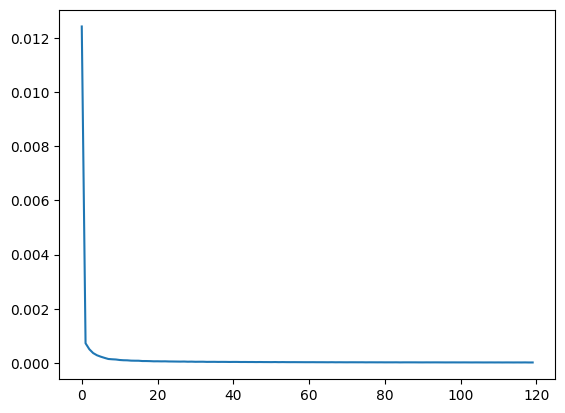

In [39]:
lr = 0.001
epochs = 120
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

torch.manual_seed(0)
model = LeNet5().to(device)
# model.apply(weight_init)
# print(model)
# summary(model, (1, 3, 255))
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 模型训练
train_losses, val_losses = [], []
print("开始训练")
for epoch in range(epochs):
    model.train()
    train_loss, val_loss = 0.0, 0.0
    
    # 训练
    for X, y in train_dataloader:
        optimizer.zero_grad()
        X, y = X.to(device), y.squeeze().to(device)
        preds = model(X).squeeze()
        loss = criterion(preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(train_dataloader)
    train_losses.append(epoch_loss)
    print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")

    model_name = "lenet5_viq_epoch_" + str(epoch + 1) + ".pth"
    model_path = os.path.join("/home/lxh/battery_phm/checkpoints/2023_4_25_ts2img_cnn_models", model_name)
    # 每10个epoch保存一次模型
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), model_path)
        print(f"model saved to: {model_path}")

print("训练完成")

plt.plot(train_losses)

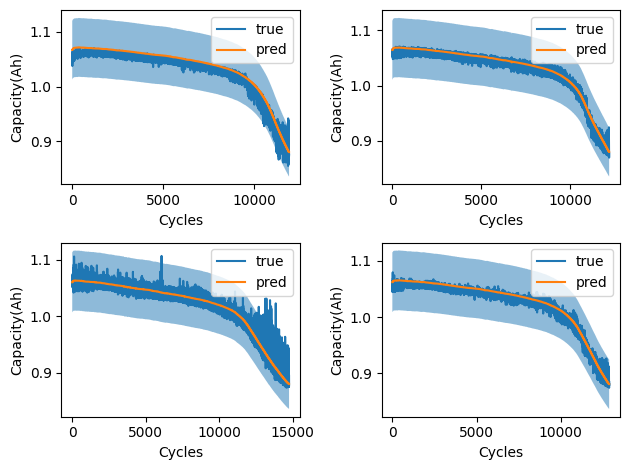

In [47]:
# 模型评估
model = LeNet5().to(device)
model.load_state_dict(torch.load("../checkpoints/2023_4_25_ts2img_cnn_models/lenet5_viq_epoch_90.pth"))
data_path = "../data/124_commercial_batteries/ts2img_dataset/"
data_files = sorted(glob.glob(os.path.join(data_path, "*.npy")))
gt_plot, pred_plot, y1_plot, y2_plot = dict(), dict(), dict(), dict()
test_num = 4
for i in range(test_num):
    test_index = i
    test_dataset = np.load(data_files[test_index], allow_pickle=True)
    test_dataset = BatteryDataset(test_dataset)
    test_dataloader = DataLoader(test_dataset, batch_size=1)
    gt, pred = [], []
    for X, y in test_dataloader:
        gt.append(float(y))
        pred.append(float(model(X.to(device))))
    gt = np.array(gt)
    y1 = gt * (1 + 0.05)
    y2 = gt * (1 - 0.05)
    y1_plot[i], y2_plot[i], gt_plot[i], pred_plot[i] = y1, y2, gt, pred


fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(pred_plot[0])
axes[0, 0].plot(gt_plot[0])
axes[0, 0].fill_between(np.arange(len(gt_plot[0])), y2_plot[0], y1_plot[0], alpha=0.5)

axes[0, 1].plot(pred_plot[1])
axes[0, 1].plot(gt_plot[1])
axes[0, 1].fill_between(np.arange(len(gt_plot[1])), y2_plot[1], y1_plot[1], alpha=0.5)

axes[1, 0].plot(pred_plot[2])
axes[1, 0].plot(gt_plot[2])
axes[1, 0].fill_between(np.arange(len(gt_plot[2])), y2_plot[2], y1_plot[2], alpha=0.5)

axes[1, 1].plot(pred_plot[3])
axes[1, 1].plot(gt_plot[3])
axes[1, 1].fill_between(np.arange(len(gt_plot[3])), y2_plot[3], y1_plot[3], alpha=0.5)

for i in range(2):
    for j in range(2):
        axes[i, j].set_xlabel("Cycles")
        axes[i, j].set_ylabel("Capacity(Ah)")
        axes[i, j].legend(["true", "pred"], loc="upper right")
plt.tight_layout()